# Plan of the notebook

This notebook follows the plan:
- Import the modules and data
- Natural Language Processing
    - Import data
    - Sentiment analysis
    - Most common words
    - Stratification per genre

# Import the modules and data

In [9]:
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pickle
#from wordcloud import WordCloud
%matplotlib inline

In [10]:
# File and folder names
DATA_FOLDER = 'Data/'
CHARACTER_DATASET = DATA_FOLDER + 'characters.pkl'
MOVIE_DATASET = DATA_FOLDER + 'movies.pkl'

SUMMARIES_DATASET = DATA_FOLDER + 'plot_summaries.txt'

MALE_SENTENCES = DATA_FOLDER + "male_sentences.pkl"
FEMALE_SENTENCES = DATA_FOLDER + "female_sentences.pkl"

MALE_SENTENCES_LEMMATIZED = DATA_FOLDER + "male_sentences_lem.pkl"
FEMALE_SENTENCES_LEMMATIZED = DATA_FOLDER + "female_sentences_lem.pkl"

MALE_SENTIMENTS = DATA_FOLDER + "male_sentiments.pkl"
FEMALE_SENTIMENTS = DATA_FOLDER + "female_sentiments.pkl"

In [11]:
# Function to load data
def load_metadata(path, column_names, header=None, low_memory=False):
    return pd.read_table(path, header=header, names=column_names)

In [12]:
# Load data
characters = pd.read_pickle(CHARACTER_DATASET)
movies = pd.read_pickle(MOVIE_DATASET)

# Little cleaning

As we pickled our data, we just have to turn the dates back to the pandas datetime format.

We also keep a version of our datasets without dropping the NaN (which are quite numerous, see below).

## Dates as datetime

Change the format of dates

In [13]:
movies.Movie_release_date = pd.to_datetime(movies.Movie_release_date,format='%Y').dt.year
characters.Movie_release_date = pd.to_datetime(characters.Movie_release_date,format='%Y').dt.year
characters.Actor_date_of_birth = pd.to_datetime(characters.Actor_date_of_birth,format='%Y',utc=True,errors='coerce').dt.year

In [ ]:
characters = characters.dropna()
movies = movies.dropna()

Conversion of gender to {0,1} (0 for male, 1 for female).

In [8]:
characters.Actor_gender = (characters.Actor_gender=='F').apply(int)
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,1,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,0,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,1,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006.0,Taper Guy,1971.0,0,1.87,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999.0,Sandii,1975.0,1,1.68,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


# Natural language processing

## Import the data

In [9]:
# Import male sentences
male_sentences_dict = pd.read_pickle(MALE_SENTENCES)
# Form a dataframe
male_sentences = pd.DataFrame(list(male_sentences_dict.items()), columns = ['id','sentences'])
# Create a new column that reconstructs the summary from the lemmatized sentences
male_sentences['summary'] = male_sentences['sentences'].apply(lambda x: ' '.join(x))

# Show the first 5 rows
male_sentences.head()

,id,sentences,summary
0,3217,"[After being pulled through a time portal, Ash...","After being pulled through a time portal, Ash ..."
1,3333,[ The film follows two juxtaposed families: th...,The film follows two juxtaposed families: the...
2,3746,"[{{Hatnote}} In Los Angeles, November 2019, re...","{{Hatnote}} In Los Angeles, November 2019, ret..."
3,3837,"[In the American Old West of 1874, constructio...","In the American Old West of 1874, construction..."
4,3947,[Jeffrey Beaumont returns to his logging home...,Jeffrey Beaumont returns to his logging home ...


In [10]:
# Import female sentences
female_sentences_dict = pd.read_pickle(FEMALE_SENTENCES)
# Form a dataframe
female_sentences = pd.DataFrame(list(female_sentences_dict.items()), columns = ['id','sentences'])
# Create a new column that reconstructs the summary from the lemmatized sentences
female_sentences['summary'] = female_sentences['sentences'].apply(lambda x: ' '.join(x))

# Show the first 5 rows
female_sentences.head()

,id,sentences,summary
0,330,[In order to prepare the role of an important ...,In order to prepare the role of an important o...
1,3217,"[ However, Sheila is captured by a Flying Dead...","However, Sheila is captured by a Flying Deadi..."
2,3333,"[ Elsie takes Cameron's mother, who has travel...","Elsie takes Cameron's mother, who has travele..."
3,3746,[ Sent to the Tyrell Corporation to ensure tha...,Sent to the Tyrell Corporation to ensure that...
4,3947,"[ Increasingly curious, Jeffrey enters Dorothy...","Increasingly curious, Jeffrey enters Dorothy'..."


## Analyse sentiments for each group

In [11]:
# Takes 10s to run (on i7-10875H CPU)

# Read files
female_sentiments = pd.read_pickle(FEMALE_SENTIMENTS)
male_sentiments = pd.read_pickle(MALE_SENTIMENTS)

# Add new columns containing the sentiment scores
female_sentiments = pd.concat([female_sentiments, female_sentiments['polarity'].apply(pd.Series)], axis=1)
male_sentiments = pd.concat([male_sentiments, male_sentiments['polarity'].apply(pd.Series)], axis=1)

# Define a sentiment base on compound score
female_sentiments['sentiment'] = female_sentiments['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
male_sentiments['sentiment'] = male_sentiments['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

# Show the first 5 rows for male sentiments
male_sentiments.head()

,id,sentences,summary,polarity,neg,neu,pos,compound,sentiment
0,3217,"[After being pulled through a time portal, Ash...","After being pulled through a time portal, Ash ...","{'neg': 0.147, 'neu': 0.791, 'pos': 0.062, 'co...",0.147,0.791,0.062,-0.9843,negative
1,3333,[ The film follows two juxtaposed families: th...,The film follows two juxtaposed families: the...,"{'neg': 0.048, 'neu': 0.899, 'pos': 0.053, 'co...",0.048,0.899,0.053,0.0129,positive
2,3746,"[{{Hatnote}} In Los Angeles, November 2019, re...","{{Hatnote}} In Los Angeles, November 2019, ret...","{'neg': 0.109, 'neu': 0.776, 'pos': 0.114, 'co...",0.109,0.776,0.114,0.6837,positive
3,3837,"[In the American Old West of 1874, constructio...","In the American Old West of 1874, construction...","{'neg': 0.103, 'neu': 0.84, 'pos': 0.058, 'com...",0.103,0.840,0.058,-0.9590,negative
4,3947,[Jeffrey Beaumont returns to his logging home...,Jeffrey Beaumont returns to his logging home ...,"{'neg': 0.142, 'neu': 0.841, 'pos': 0.017, 'co...",0.142,0.841,0.017,-0.9928,negative


In [12]:
# Prepare for plotting
num_rows_female = len(female_sentiments)
num_rows_male = len(male_sentiments)

# Label names
names = ["Positive", "Neutral", "Negative"]

# Count the number of positive, neutral and negative sentences
positive_male = male_sentiments['sentiment'].value_counts()['positive']
neutral_male = male_sentiments['sentiment'].value_counts()['neutral']
negative_male = male_sentiments['sentiment'].value_counts()['negative']

percentages_male = [positive_male/num_rows_male, neutral_male/num_rows_male, negative_male/num_rows_male]

positive_female = female_sentiments['sentiment'].value_counts()['positive']
neutral_female = female_sentiments['sentiment'].value_counts()['neutral']
negative_female = female_sentiments['sentiment'].value_counts()['negative']

percentages_female = [positive_female/num_rows_female, neutral_female/num_rows_female, negative_female/num_rows_female]

Text(0.5, 1.0, 'Sentiment distribution for male sentences')

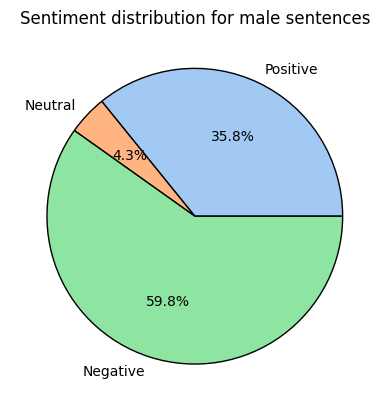

In [13]:
# Plot the distribution of the sentiment for male sentences
# sns.countplot(y='sentiment', data=male_sentiments, palette=['#b2d8d8',"#008080", '#db3d13'])
colors = sns.color_palette('pastel')[0:3]
plt.pie(percentages_male, labels = names, colors = colors, autopct='%.1f%%',wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'} )
plt.title('Sentiment distribution for male sentences')

Text(0.5, 1.0, 'Sentiment distribution for female sentences')

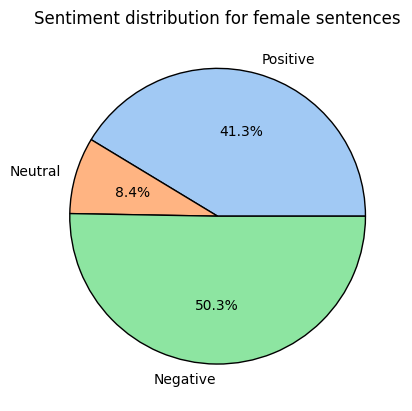

In [14]:
# Plot the distribution of the sentiment for female sentences
colors = sns.color_palette('pastel')[0:3]
plt.pie(percentages_female, labels = names, colors = colors, autopct='%.1f%%',wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'})
plt.title('Sentiment distribution for female sentences')

In [15]:
# Create new data frame with setences and compound score for male
temp_male = male_sentiments[['sentences', 'compound']].copy()
# Add column with the value male to the data frame
temp_male["sex"] = "M"
print("Male mean coumpound :", temp_male['compound'].mean())

# Create new data frame with setences and compound score for male
temp_female = female_sentiments[['sentences', 'compound']].copy()
# Add column with the value male to the data frame
temp_female["sex"] = "F"
print("Female mean coumpound :",temp_female['compound'].mean())

regression = pd.concat([temp_female, temp_male], axis=0)

Male mean coumpound : -0.2166389401537947
Female mean coumpound : -0.0779040443440772


In [16]:
from statsmodels.formula.api import ols

fit = ols('compound ~ C(sex)', data=regression).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     485.1
Date:                Thu, 22 Dec 2022   Prob (F-statistic):          5.51e-107
Time:                        22:06:06   Log-Likelihood:                -51342.
No. Observations:               49394   AIC:                         1.027e+05
Df Residuals:                   49392   BIC:                         1.027e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0779      0.005    -15.893      0.000      -0.088      -0.068
C(sex)[T.M]    -0.1387      0.006    -22.024      0.000      -0.151      -0.126
==============================================================================
Omnibus:                   619396.500   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4672.781
Skew:                           0.314   Prob(JB):                         0.00
Kurtosis:                       1.630   Cond. No.                         2.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

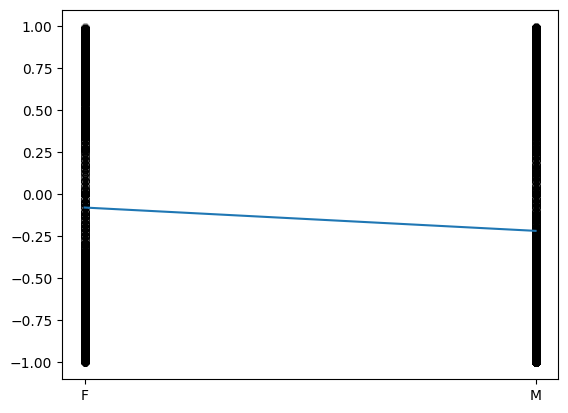

In [17]:
p = fit.params

# scatter-plot data
plt.scatter(regression["sex"], regression["compound"], color='k', alpha=0.005)

x = np.arange(0, 2)
# plot regression line on the same axes, set x-axis limits
plt.plot(x, p[0] + p[1] * x)
# plt.set_xlim([1, 2])

## Most common words

In [19]:
female_sentences_lem_dict = pd.read_pickle(FEMALE_SENTENCES_LEMMATIZED)
male_sentences_lem_dict = pd.read_pickle(MALE_SENTENCES_LEMMATIZED)

male_sentences_lem = pd.DataFrame(list(male_sentences_lem_dict.items()), columns = ['id','sentences'])
female_sentences_lem = pd.DataFrame(list(male_sentences_lem_dict.items()), columns = ['id','sentences'])

In [20]:
male_sentences_lem.head()

,id,sentences
0,3217,"[after be pull through a time portal , he land..."
1,3333,[the film follow two juxtapose family : the no...
2,3746,[-lcb- -lcb- hatnote -rcb- -rcb- in los angele...
3,3837,"[in the american old west of 1874 , constructi..."
4,3947,[he return to he log home town of lumberton fr...


In [21]:
# Create a list containing all the male sentences for every plot
list_male = male_sentences_lem['sentences'].tolist()
total_list_male = [item for sublist in list_male for item in sublist]

# Remove the lrb tag
for i in range(len(total_list_male)):
    if total_list_male[i].find('lrb') != -1:
        total_list_male[i] = total_list_male[i].replace('lrb', '')

total_array_of_words_male = ' '.join([word for word in total_list_male])

# Create a list containing all the female sentences for every plot
list_female = female_sentences_lem['sentences'].tolist()
total_list_female = [item for sublist in list_female for item in sublist]

# Remove the lrb tag
for i in range(len(total_list_female)):
    if total_list_female[i].find('lrb') != -1:
        total_list_female[i] = total_list_female[i].replace('lrb', '')

total_array_of_words_female = ' '.join([word for word in total_list_female])

In [22]:
from PIL import Image
mask_male = np.array(Image.open(r'male.png'))
mask_female = np.array(Image.open(r'female.png'))
def transform_zeros(val):
    if val == 0: 
       return 255
    else:
       return val
maskable_male = np.ndarray((mask_male.shape[0],mask_male.shape[1]), np.int32)
maskable_female = np.ndarray((mask_female.shape[0],mask_female.shape[1]), np.int32)
for i in range(len(mask_male)):
    maskable_male[i] = list(map(transform_zeros, mask_male[i]))
    maskable_female[i] = list(map(transform_zeros, mask_female[i]))
mask_female = maskable_female
mask_male = maskable_male

In [23]:
# Define colors
import matplotlib

min_val, max_val = 0.6,1.0
n = 10
orig_cmap = plt.cm.Purples
colors_purples = orig_cmap(np.linspace(min_val, max_val, n))
cmap_purples = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors_purples)

orig_cmap = plt.cm.Blues
colors_blues = orig_cmap(np.linspace(min_val, max_val, n))
cmap_blues = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors_blues)

(-0.5, 569.5, 569.5, -0.5)

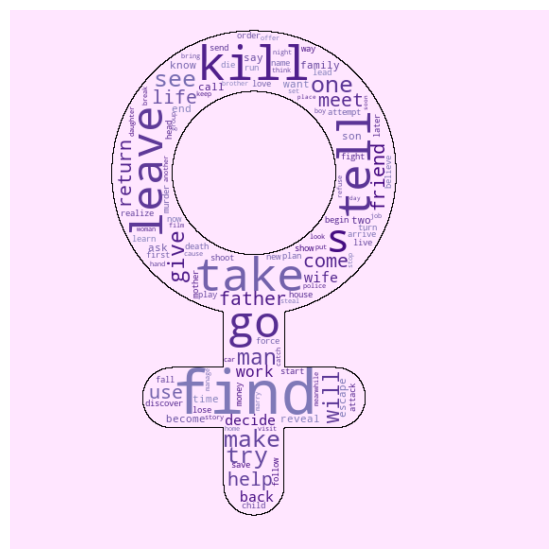

In [24]:
from wordcloud import WordCloud

# Plot Data for female sentences
wordcloud = WordCloud(width=mask_female.shape[1], height=mask_female.shape[0], colormap=cmap_purples, background_color="#ffe6ff", contour_width =1, mask = mask_female, random_state=2, max_font_size=100, min_font_size=6).generate(total_array_of_words_female)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 569.5, 569.5, -0.5)

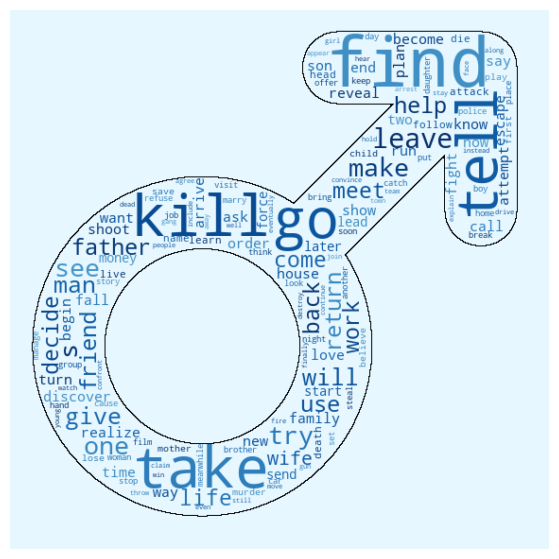

In [25]:
# Plot Data for male sentences
wordcloud = WordCloud(width=mask_male.shape[1], height=mask_male.shape[0], colormap=cmap_blues, background_color="#e6f7ff", mask = mask_male, contour_width =1, random_state=2, max_font_size=100, min_font_size=6).generate(total_array_of_words_male)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [26]:
ah = pd.read_pickle(DATA_FOLDER+"Indie_male_sentences_lem.pkl")
# Define DataFrame from dictionary
ah = pd.DataFrame(list(ah.items()), columns = ['id','sentences'])

## Which words are more masculine/feminine for each movie genre?

In [57]:
import plotly.express as px
movie_id_per_genre = pd.read_pickle(DATA_FOLDER+"movies_id_per_genres.pkl")
# Keep only Action, Romance and Comedy
movie_id_per_genre = {k: v for k, v in movie_id_per_genre.items() if k in ["Action", "Romance Film", "Comedy"]}

for genre in movie_id_per_genre:
    most_feminine_words = pd.read_pickle(DATA_FOLDER+genre+"_most_feminine_words.pkl")
    most_masculine_words = pd.read_pickle(DATA_FOLDER+genre+"_most_masculine_words.pkl")

    stopwords = ["preghecy", "eun-jin", "maya", "pregshet", "ko", "sh", "heny", "lieutehet"]
    most_feminine_words = [word for word in most_feminine_words if word[0] not in stopwords]
    most_masculine_words = [word for word in most_masculine_words if word[0] not in stopwords]

    # Create a DataFrame from the list of most feminine words
    most_feminine_words = pd.DataFrame(most_feminine_words, columns = ['word','total','ratio'])
    most_masculine_words = pd.DataFrame(most_masculine_words, columns = ['word','total','ratio'])
    
    # Save 10 most feminine words in new DataFrame
    most_feminine_words_x = most_feminine_words.head(10)
    most_masculine_words_x = most_masculine_words.head(10)

    # multiply value by 100 to have a percentage
    most_feminine_words_x['ratio'] = most_feminine_words_x['ratio']*100
    most_masculine_words_x['ratio'] = most_masculine_words_x['ratio']*100

    # Sort the values
    most_feminine_words_x = most_feminine_words_x.sort_values(by='ratio', ascending=True)
    most_masculine_words_x = most_masculine_words_x.sort_values(by='ratio', ascending=True)
    

    if genre == "Romance Film":
        genre = "Romance"
    fig = px.bar(most_masculine_words_x, x='ratio', y='word', orientation='h', title='Most masculine words in '+genre+' movies')
    fig.update_layout(
        # autosize=False,
        width=500,
        height=800,
        margin=dict(l=20, r=20, t=50, b=20),)
    fig.update_traces(marker_color='#4374B3')
    fig.update_layout(title_x=0.5)
    fig.update_layout({
        'plot_bgcolor': 'rgba(0,0,0,0)',
        'paper_bgcolor': 'rgba(0,0,0,0)'
    })
    # Rename axis
    fig.update_xaxes(title_text='Percentage of chance to be in a masculine sentence')
    fig.update_yaxes(title_text='Word')

    fig.update_xaxes(range=[85, 100])
    # Save the figure
    fig.write_image("words/"+genre+"_most_masculine_words.png")

    # fig.show()

    fig2 = px.bar(most_feminine_words_x, x='ratio', y='word', orientation='h', title='Most feminine words in '+genre+' movies')
    fig2.update_layout(
        # autosize=False,
        width=500,
        height=800,
        margin=dict(l=20, r=20, t=50, b=20),)
    fig2.update_traces(marker_color='#FF69B4')
    fig2.update_xaxes(title_text='Percentage of chance to be in a feminine sentence')
    fig2.update_yaxes(title_text='Word')
    fig2.update_yaxes(title_text='Word')
    fig2.update_layout({
        'plot_bgcolor': 'rgba(0,0,0,0)',
        'paper_bgcolor': 'rgba(0,0,0,0)'
    })

    fig2.update_xaxes(range=[85, 100])
    fig2.update_layout(title_x=0.5)
    # fig2.show()
    fig2.write_image("words/"+genre+"_most_feminine_words.png")

C:\Users\Pierre\AppData\Local\Temp\ipykernel_26684\2120622959.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Pierre\AppData\Local\Temp\ipykernel_26684\2120622959.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Pierre\AppData\Local\Temp\ipykernel_26684\2120622959.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [58]:
# Takes 10s to run (on i7-10875H CPU)

# Read files
female_sentiments = pd.read_pickle(FEMALE_SENTIMENTS)
male_sentiments = pd.read_pickle(MALE_SENTIMENTS)

# Add new columns containing the sentiment scores
female_sentiments = pd.concat([female_sentiments, female_sentiments['polarity'].apply(pd.Series)], axis=1)
male_sentiments = pd.concat([male_sentiments, male_sentiments['polarity'].apply(pd.Series)], axis=1)

# Define a sentiment base on compound score
female_sentiments['sentiment'] = female_sentiments['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
male_sentiments['sentiment'] = male_sentiments['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

# Show the first 5 rows for male sentiments
male_sentiments.head()

,id,sentences,summary,polarity,neg,neu,pos,compound,sentiment
0,3217,"[After being pulled through a time portal, Ash...","After being pulled through a time portal, Ash ...","{'neg': 0.147, 'neu': 0.791, 'pos': 0.062, 'co...",0.147,0.791,0.062,-0.9843,negative
1,3333,[ The film follows two juxtaposed families: th...,The film follows two juxtaposed families: the...,"{'neg': 0.048, 'neu': 0.899, 'pos': 0.053, 'co...",0.048,0.899,0.053,0.0129,positive
2,3746,"[{{Hatnote}} In Los Angeles, November 2019, re...","{{Hatnote}} In Los Angeles, November 2019, ret...","{'neg': 0.109, 'neu': 0.776, 'pos': 0.114, 'co...",0.109,0.776,0.114,0.6837,positive
3,3837,"[In the American Old West of 1874, constructio...","In the American Old West of 1874, construction...","{'neg': 0.103, 'neu': 0.84, 'pos': 0.058, 'com...",0.103,0.840,0.058,-0.9590,negative
4,3947,[Jeffrey Beaumont returns to his logging home...,Jeffrey Beaumont returns to his logging home ...,"{'neg': 0.142, 'neu': 0.841, 'pos': 0.017, 'co...",0.142,0.841,0.017,-0.9928,negative


In [59]:
male_sentiments.head()

,id,sentences,summary,polarity,neg,neu,pos,compound,sentiment
0,3217,"[After being pulled through a time portal, Ash...","After being pulled through a time portal, Ash ...","{'neg': 0.147, 'neu': 0.791, 'pos': 0.062, 'co...",0.147,0.791,0.062,-0.9843,negative
1,3333,[ The film follows two juxtaposed families: th...,The film follows two juxtaposed families: the...,"{'neg': 0.048, 'neu': 0.899, 'pos': 0.053, 'co...",0.048,0.899,0.053,0.0129,positive
2,3746,"[{{Hatnote}} In Los Angeles, November 2019, re...","{{Hatnote}} In Los Angeles, November 2019, ret...","{'neg': 0.109, 'neu': 0.776, 'pos': 0.114, 'co...",0.109,0.776,0.114,0.6837,positive
3,3837,"[In the American Old West of 1874, constructio...","In the American Old West of 1874, construction...","{'neg': 0.103, 'neu': 0.84, 'pos': 0.058, 'com...",0.103,0.840,0.058,-0.9590,negative
4,3947,[Jeffrey Beaumont returns to his logging home...,Jeffrey Beaumont returns to his logging home ...,"{'neg': 0.142, 'neu': 0.841, 'pos': 0.017, 'co...",0.142,0.841,0.017,-0.9928,negative


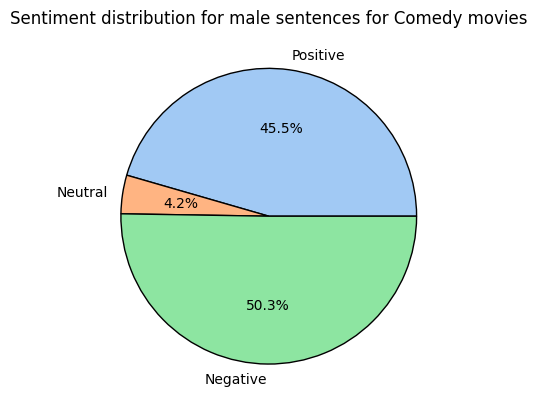

<Figure size 640x480 with 0 Axes>

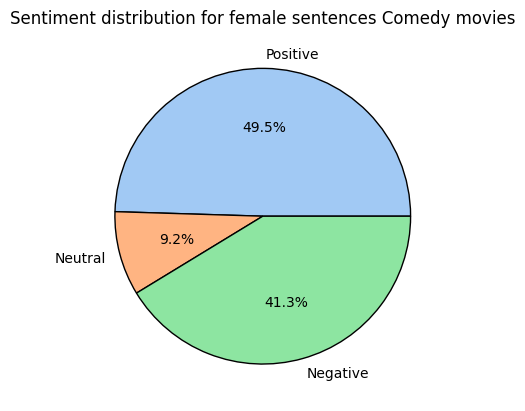

<Figure size 640x480 with 0 Axes>

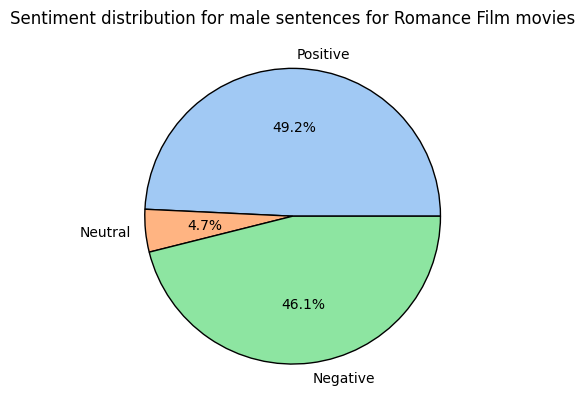

<Figure size 640x480 with 0 Axes>

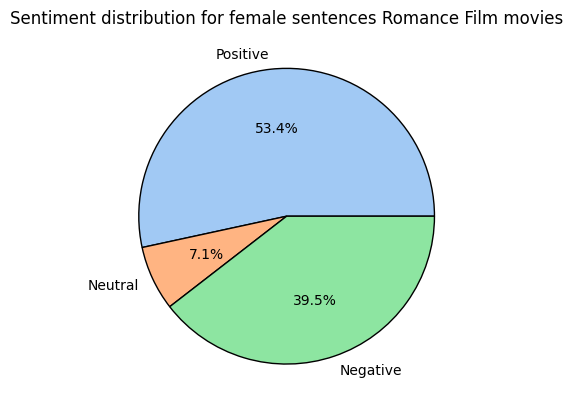

<Figure size 640x480 with 0 Axes>

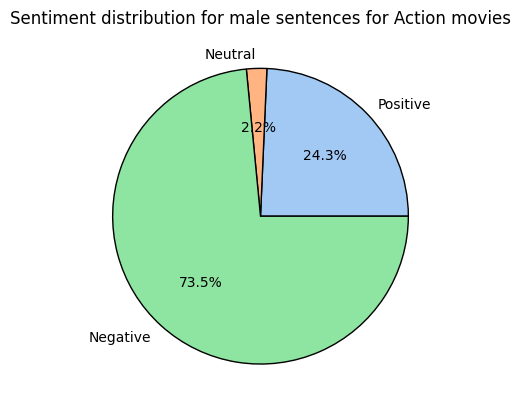

<Figure size 640x480 with 0 Axes>

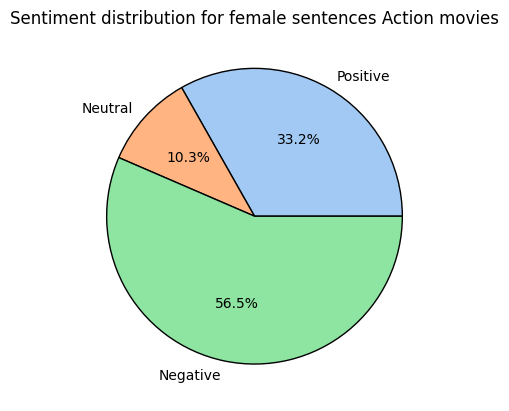

<Figure size 640x480 with 0 Axes>

In [61]:

# Label names
names = ["Positive", "Neutral", "Negative"]
# Read movie_id_per_genre
movie_id_per_genre = pd.read_pickle(DATA_FOLDER+"movies_id_per_genres.pkl")
movie_id_per_genre = {k: v for k, v in movie_id_per_genre.items() if k in ["Action", "Romance Film", "Comedy"]}

for genre in movie_id_per_genre:
    # Get the list of movie ids for this genre
    movie_ids = movie_id_per_genre[genre]
    # Select only movie ids that are in the list in male_sentiments and female_sentiments
    temp_male_sentiments = male_sentiments[male_sentiments['id'].isin(movie_ids)]
    temp_female_sentiments = female_sentiments[female_sentiments['id'].isin(movie_ids)]

    num_rows_female = len(temp_female_sentiments)
    num_rows_male = len(temp_male_sentiments)

    # Count the number of positive, neutral and negative sentences
    positive_male = temp_male_sentiments['sentiment'].value_counts()['positive']
    neutral_male = temp_male_sentiments['sentiment'].value_counts()['neutral']
    negative_male = temp_male_sentiments['sentiment'].value_counts()['negative']

    percentages_male = [positive_male/num_rows_male, neutral_male/num_rows_male, negative_male/num_rows_male]

    positive_female = temp_female_sentiments['sentiment'].value_counts()['positive']
    neutral_female = temp_female_sentiments['sentiment'].value_counts()['neutral']
    negative_female = temp_female_sentiments['sentiment'].value_counts()['negative']

    percentages_female = [positive_female/num_rows_female, neutral_female/num_rows_female, negative_female/num_rows_female]

    # Plot the distribution of the sentiment for male sentences
    # sns.countplot(y='sentiment', data=male_sentiments, palette=['#b2d8d8',"#008080", '#db3d13'])
    colors = sns.color_palette('pastel')[0:3]
    fig, ax = plt.subplots()
    ax = plt.pie(percentages_male, labels = names, colors = colors, autopct='%.1f%%',wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'} )
    ax= plt.title('Sentiment distribution for male sentences for '+genre+' movies')
    plt.show()
    # Save plot
    # fig.savefig("sentiments/"+genre+"_male_sentiments.png")

    # Clear plot
    plt.clf()

    fig2, ax2= plt.subplots()
    # Plot the distribution of the sentiment for female sentences
    ax2 = plt.pie(percentages_female, labels = names, colors = colors, autopct='%.1f%%',wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'})
    ax2 = plt.title('Sentiment distribution for female sentences '+genre+' movies')
    # fig2.savefig("sentiments/"+genre+"_female_sentiments.png")
    plt.show()

    # Clear plot
    plt.clf()

In [ ]:
# Plot the distribution of the sentiment for male sentences
# sns.countplot(y='sentiment', data=male_sentiments, palette=['#b2d8d8',"#008080", '#db3d13'])
colors = sns.color_palette('pastel')[0:3]
plt.pie(percentages_male, labels = names, colors = colors, autopct='%.1f%%',wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'} )
plt.title('Sentiment distribution for male sentences')

# Plot the distribution of the sentiment for female sentences
colors = sns.color_palette('pastel')[0:3]
plt.pie(percentages_female, labels = names, colors = colors, autopct='%.1f%%',wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'})
plt.title('Sentiment distribution for female sentences')